In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import json

from PIL import Image
from google import genai

import tt

(640, 640)


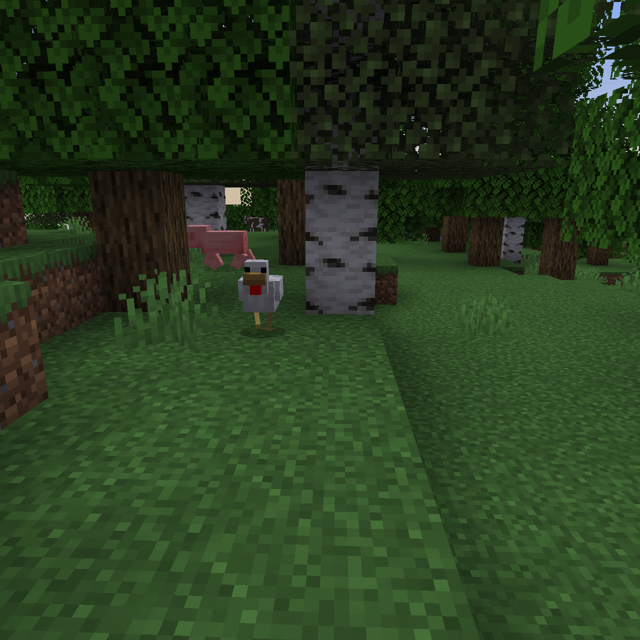

In [3]:
mobs_path = Path.home() / "src/data/mobs1/images"
image_fname = mobs_path / '06092b21-2024-10-20_22.22.09.png'
image = Image.open(image_fname)
image640 = image.resize((image.width // 2, image.height // 2))
print(image640.size)
display(image640)

In [4]:
CLASSES = [ 'chicken', 'cow', 'creeper', 'enderman', 'pig', 'player', 'sheep',
'skeleton', 'spider', 'villager', 'zombie' ]
CLASSES.sort()
CLASSES_MINECRAFT = [f"minecraft {x}" for x in CLASSES]

In [5]:
from google import genai
def gemini_detect(image: Image.Image, prompt: str, tempurature: float | None = None, seed: int | None = None) -> None:
    client = genai.Client()
    config = genai.types.GenerateContentConfig(
        response_mime_type="application/json",
        thinking_config=genai.types.ThinkingConfig(thinking_budget=0),
        temperature=tempurature)
    response = client.models.generate_content(model="gemini-2.5-flash", contents=[image, prompt], config=config)

    bounding_boxes = json.loads(response.text)
    return bounding_boxes

In [6]:
temp = 0.0
seed = 325
prompt_short = f"""Detect {", ".join(CLASSES)}."""

image_detect = image640.copy()

bbox_short = gemini_detect(image_detect, prompt_short, tempurature=temp, seed=seed)
print(bbox_short)

# bboxes = tt.gemini_to_bboxes(gemini_bboxes)
# print(bboxes)

[{'box_2d': [399, 368, 516, 443], 'label': 'chicken'}, {'box_2d': [333, 377, 369, 415], 'label': 'cow'}, {'box_2d': [356, 292, 434, 397], 'label': 'pig'}]


In [7]:
display(tt.bbs_to_df(tt.gemini_to_bboxes(bbox_short)))

,label,x1,y1,x2,y2
0,chicken,0.368,0.399,0.443,0.516
1,cow,0.377,0.333,0.415,0.369
2,pig,0.292,0.356,0.397,0.434


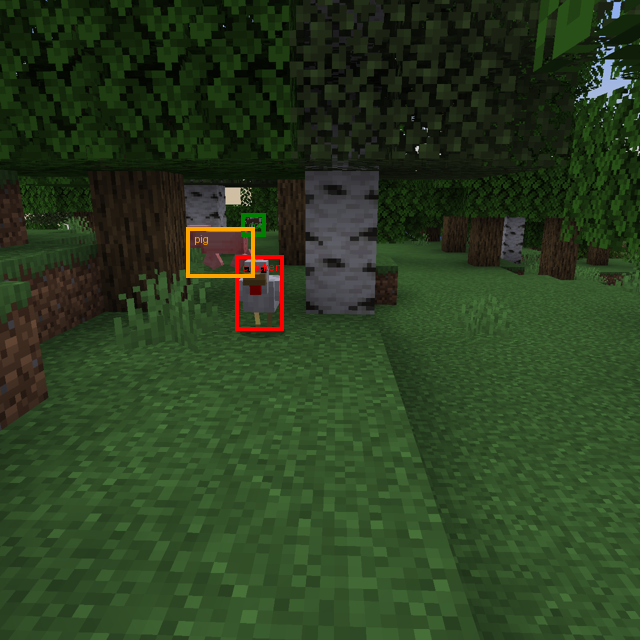

In [8]:
# plot_bounding_boxes(image640, bbox_short)
display(tt.plot_bb(image640, tt.gemini_to_bboxes(bbox_short), CLASSES))